In [193]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from ensemble_tabpfn import EnsembleTabPFN
from tabpfn import TabPFNClassifier

In [194]:
zero_noise = pd.read_csv("data/zero_noise.csv")
low_noise = pd.read_csv("data/low_noise.csv")
high_noise = pd.read_csv("data/high_noise.csv")
low_noise.drop(columns=["data_type"], inplace=True)
high_noise.drop(columns=["data_type"], inplace=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [195]:
def encode(v, class_values):
    return class_values.index(v)

def encode_target(v, class_values):
    return class_values.index(v)

class_values_zero = list(zero_noise.era.unique())
zero_noise["era_label"] = zero_noise["era"].apply(encode, args=(class_values_zero,))

class_values_low = list(low_noise.era.unique())
class_values_low_target_5 = list(low_noise.target_5_val.unique())
class_values_low_target_10 = list(low_noise.target_10_val.unique())
low_noise["era_label"] = low_noise["era"].apply(encode, args=(class_values_low,))
low_noise["target_5_val_label"] = low_noise["target_5_val"].apply(encode_target, args=(class_values_low_target_5,))
low_noise["target_10_val_label"] = low_noise["target_10_val"].apply(encode_target, args=(class_values_low_target_10,))

class_values_high = list(high_noise.era.unique())
class_values_high_target_5 = list(high_noise.target_5_val.unique())
class_values_high_target_10 = list(high_noise.target_10_val.unique())
high_noise["era_label"] = high_noise["era"].apply(encode, args=(class_values_high,))
high_noise["target_5_val_label"] = high_noise["target_5_val"].apply(encode_target, args=(class_values_high_target_5,))
high_noise["target_10_val_label"] = high_noise["target_10_val"].apply(encode_target, args=(class_values_high_target_10,))

dataset = low_noise
target_column = "era_label"
output_classes = 12 if target_column=="era_label" else 5
window = 5 if target_column=="target_5_val_label" else 10

In [196]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return (
            torch.Tensor(self.X[index:index+window]),
            torch.tensor(self.y[index], dtype=torch.long),
        )

In [197]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))

dataset = dataset.sample(frac=1).reset_index(drop=True)
train_dataset = dataset.iloc[:train_size]
val_dataset = dataset.iloc[train_size:train_size+val_size]
test_dataset = dataset.iloc[train_size+val_size:]

train_X = train_dataset.iloc[:, :-8].values
train_y = train_dataset.loc[:, target_column].values

val_X = val_dataset.iloc[:, :-8].values
val_y = val_dataset.loc[:, target_column].values

test_X = test_dataset.iloc[:, :-8].values
test_y = test_dataset.loc[:, target_column].values

In [198]:
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)
test_dataset = CustomDataset(test_X, test_y)

train_batch_size = 256
val_batch_size = 256
test_batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=val_batch_size, shuffle=False)

In [199]:
# X_train_1 = torch.Tensor(train_X[0:5]).unsqueeze(0)
# X_train_2 = torch.Tensor(train_X[5:10]).unsqueeze(0)
# X_train_3 = torch.Tensor(train_X[10:15]).unsqueeze(0)
# X_train = torch.cat((X_train_1, X_train_2,X_train_3), dim=0)

In [200]:
gru = torch.nn.GRU(input_size=24, hidden_size=64, num_layers=2, batch_first=True)

class GRUClassifier(nn.Module):
    def __init__(self, gru, output_classes):
        super().__init__()
        self.gru = gru
        self.classifier = nn.Linear(64, output_classes)

    def forward(self, x):
        x, hn = self.gru(x)
        last_hidden_state = x[:, -1, :]
        x = self.classifier(last_hidden_state)
        tau = torch.sigmoid(x)
        x = F.softmax(x, dim=1)
        return x, tau
    
class NoiseAttentionLoss(nn.Module):
    def __init__(self, lambda_=1.0):
        super(NoiseAttentionLoss, self).__init__()
        self.lambda_ = lambda_

    def forward(self, logits, y, tau):
        y = F.one_hot(y, output_classes).to(torch.float64).to(device)
        perceptual = tau.squeeze(1) * (logits.t() - y.t()) + y.t()
        attention_term = torch.matmul(y, torch.log(perceptual + 1e-8))
        attention_term = attention_term.diag()
        boost_term = torch.log(tau + 1e-10) * self.lambda_

        attention_term = -torch.mean(attention_term)
        boost_term = -torch.mean(boost_term)

        return attention_term + boost_term


criterion_gru = nn.CrossEntropyLoss()
criterion_nal = NoiseAttentionLoss(lambda_=50.0)

learning_rate_gru = 0.001
weight_decay_gru = 0.0001

optimizer_gru = torch.optim.Adam(gru.parameters(), lr=learning_rate_gru, weight_decay=weight_decay_gru)

# train the model

# train_losses = []
# val_losses = []

model = GRUClassifier(gru, output_classes).to(device)

In [201]:
def train(model, optimizer, loss_fn, epochs, train_dataloader, val_dataloader,
          bagging_mode=False, validation_mode=True, NAL_loss=False, debug_mode=False):
    
    batch=0
    val_losses=[]
    val_accuracies=[]
    train_losses=[]
    train_accuracies=[]
    num_batches=int(len(train_dataloader)*0.9)
    for epoch in tqdm(range(epochs)):
        
        train_accuracy=0.0
        train_loss=0.0
        model.train()
        batch=0
        for i, (feature, label) in enumerate(train_dataloader):
            optimizer.zero_grad()
            feature = feature.to(device)
            label = label.to(device)

            if NAL_loss:
                output, tau = model(feature)
                loss = loss_fn(output, label, tau)
            else:
                output, tau = model(feature)
                loss = loss_fn(output, label)

            loss.backward()
            optimizer.step()
            
            train_loss+=(loss.item())/len(label)
            train_accuracy+=torch.sum(torch.argmax(output, dim=1) == label)/len(label)

            batch+=1
            if bagging_mode:
                if batch==num_batches:
                    break
            if debug_mode:
                break

            if i == len(train_dataloader)-2:
                break
            
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy/len(train_dataloader))

        print(f'Epoch {epoch+1}/{epochs}')
        print('***********************************************')
        print(f"Training loss: {train_loss}")
        print(f"Training accuracy: {train_accuracy/len(train_dataloader)}")
        print("-----------------------------------------------")
        
        if validation_mode:
            val_loss, val_acc = validation(model, val_dataloader, loss_fn, NAL_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
        batch=0

    if validation_mode:
        return train_losses, train_accuracies, val_losses, val_accuracies
    else:
        return train_losses, train_accuracies
    
def validation(model, val_dataloader, criterion, NAL_loss=False):
    model.eval()
    val_accuracy = 0
    val_loss = 0
    with torch.no_grad():
        for i, (feature, label) in enumerate(val_dataloader):
            feature = feature.to(device)
            label = label.to(device)
            output, tau = model(feature)
            if NAL_loss:
                val_loss += criterion(output, label, tau).item()
            else:
                val_loss += criterion(output, label).item()
            val_accuracy += torch.sum(torch.argmax(output, dim=1) == label)/len(label)
            if i == len(val_dataloader)-2:
                break
            
        print(f"Validation loss: {val_loss/len(val_dataloader)}")
        print(f"Validation accuracy: {val_accuracy/len(val_dataloader)}")
        print()

    return val_loss/len(val_dataloader), val_accuracy/len(val_dataloader)

def plot(train, val, mode):
    if mode == "accuracy":
        for i in range(len(train)):
            train[i] = train[i].cpu().numpy()
        for i in range(len(val)):
            val[i] = val[i].cpu().numpy()
    
    plt.figure(figsize=(10, 5))
    plt.plot(train, label=f"Training {mode}")
    plt.plot(val, label=f"Validation {mode}")
    plt.title(f"Training and Validation {mode} Curve")

    plt.xlabel("Epochs")
    plt.ylabel(f"{mode}")
    plt.legend()
    plt.show()

## Low noise

### Era

In [202]:
train_loss, train_acc, val_loss, val_acc = train(model, optimizer_gru, criterion_gru, 10, train_dataloader, val_dataloader, 
                                                 bagging_mode=False, validation_mode=True, NAL_loss=False, debug_mode=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
***********************************************
Training loss: 9.454359041526914
Training accuracy: 0.08389823138713837
-----------------------------------------------
Validation loss: 2.464553117752075
Validation accuracy: 0.08263959735631943

Epoch 2/10
***********************************************
Training loss: 9.454352037981153
Training accuracy: 0.08368188887834549
-----------------------------------------------
Validation loss: 2.4645536493082516
Validation accuracy: 0.08267161250114441

Epoch 3/10
***********************************************
Training loss: 9.454365306533873
Training accuracy: 0.08360175788402557
-----------------------------------------------
Validation loss: 2.464556666671253
Validation accuracy: 0.08267161250114441

Epoch 4/10
***********************************************
Training loss: 9.454376261681318
Training accuracy: 0.08356169611215591
-----------------------------------------------
Validation loss: 2.464557710241099
Validation accura

### Target_5

In [190]:
train_loss, train_acc, val_loss, val_acc = train(model, optimizer_gru, criterion_gru, 40, train_dataloader, val_dataloader, 
                                                 bagging_mode=False, validation_mode=True, NAL_loss=False, debug_mode=False)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40
***********************************************
Training loss: 5.148521489929408
Training accuracy: 0.5592747926712036
-----------------------------------------------
Validation loss: 1.266433159836003
Validation accuracy: 0.6441789865493774

Epoch 2/40
***********************************************
Training loss: 4.79052052507177
Training accuracy: 0.6650921106338501
-----------------------------------------------
Validation loss: 1.2429762463100622
Validation accuracy: 0.6662717461585999

Epoch 3/40
***********************************************
Training loss: 4.741831566672772
Training accuracy: 0.6788781881332397
-----------------------------------------------
Validation loss: 1.2363864398393474
Validation accuracy: 0.6738601326942444

Epoch 4/40
***********************************************
Training loss: 4.725288938265294
Training accuracy: 0.6833613514900208
-----------------------------------------------
Validation loss: 1.226424250446382
Validation accuracy: 0.6

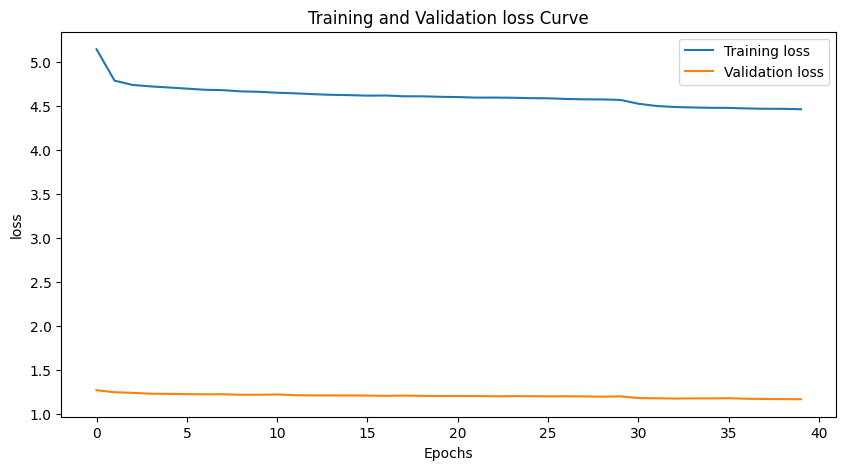

In [191]:
plot(train_loss, val_loss, "loss")

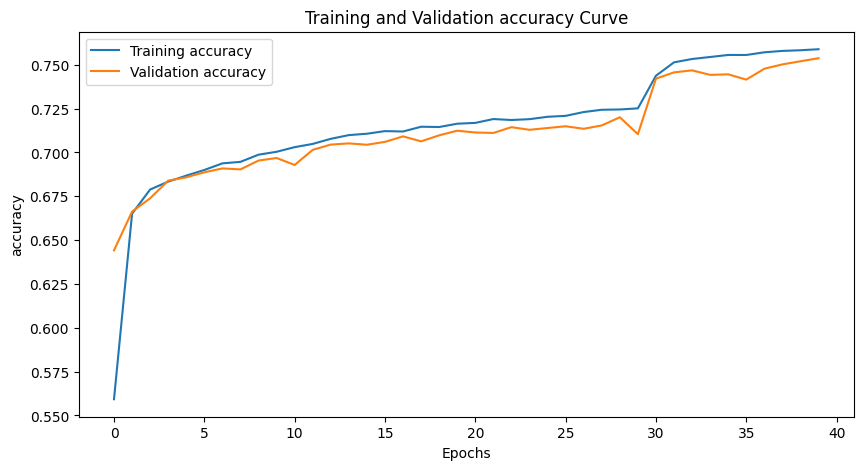

In [192]:
plot(train_acc, val_acc, "accuracy")

### Target_10

In [177]:
train_loss, train_acc, val_loss, val_acc = train(model, optimizer_gru, criterion_gru, 40, train_dataloader, val_dataloader, 
                                                 bagging_mode=False, validation_mode=True, NAL_loss=False, debug_mode=False)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40
***********************************************
Training loss: 5.350685719400644
Training accuracy: 0.4975881278514862
-----------------------------------------------
Validation loss: 1.2994007057830936
Validation accuracy: 0.6093109250068665

Epoch 2/40
***********************************************
Training loss: 4.873576159123331
Training accuracy: 0.644046425819397
-----------------------------------------------
Validation loss: 1.2535831058611635
Validation accuracy: 0.6561859250068665

Epoch 3/40
***********************************************
Training loss: 4.75479403231293
Training accuracy: 0.6759054064750671
-----------------------------------------------
Validation loss: 1.213994152233249
Validation accuracy: 0.6997630000114441

Epoch 4/40
***********************************************
Training loss: 4.653393976856023
Training accuracy: 0.704647421836853
-----------------------------------------------
Validation loss: 1.195977584260409
Validation accuracy: 0.717

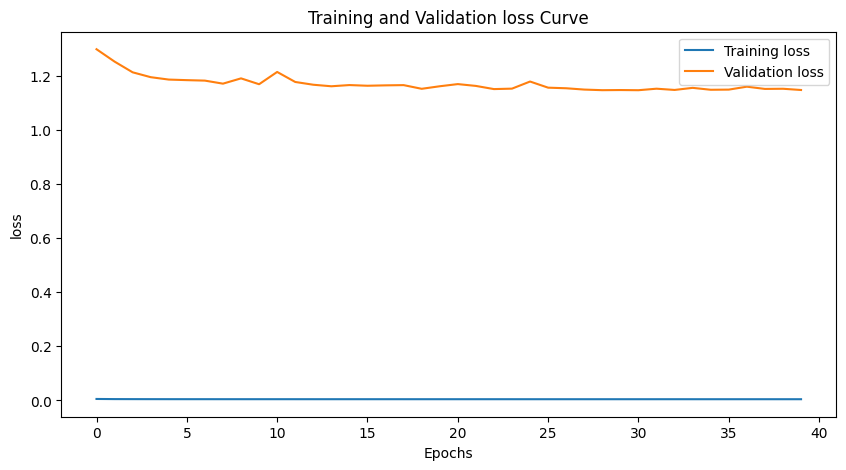

In [178]:
plot(train_loss, val_loss, "loss")

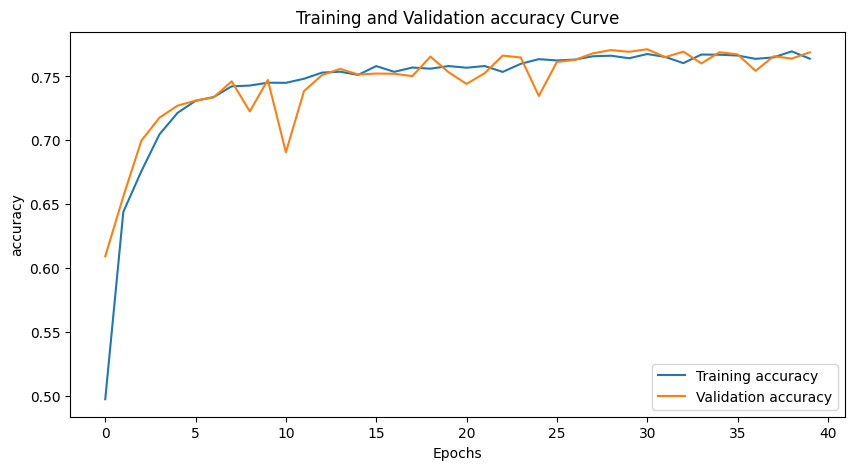

In [179]:
plot(train_acc, val_acc, "accuracy")

## High noise

### Era

In [203]:
train_loss, train_acc, val_loss, val_acc = train(model, optimizer_gru, criterion_gru, 10, train_dataloader, val_dataloader, 
                                                 bagging_mode=False, validation_mode=True, NAL_loss=False, debug_mode=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
***********************************************
Training loss: 9.454377408139408
Training accuracy: 0.08364182710647583
-----------------------------------------------
Validation loss: 2.4645580815487222
Validation accuracy: 0.0800781175494194

Epoch 2/10
***********************************************
Training loss: 9.454377916641533
Training accuracy: 0.0834294855594635
-----------------------------------------------
Validation loss: 2.4645577727771197
Validation accuracy: 0.08020619302988052

Epoch 3/10
***********************************************
Training loss: 9.454379942268133
Training accuracy: 0.08331330120563507
-----------------------------------------------
Validation loss: 2.4645595667792146
Validation accuracy: 0.08020619302988052

Epoch 4/10
***********************************************
Training loss: 9.454377309419215
Training accuracy: 0.08358173072338104
-----------------------------------------------
Validation loss: 2.4645573057112147
Validation accur

### Target_5

In [153]:
train_loss, train_acc, val_loss, val_acc = train(model, optimizer_gru, criterion_gru, 40, train_dataloader, val_dataloader, 
                                                 bagging_mode=False, validation_mode=True, NAL_loss=False, debug_mode=False)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40
***********************************************
Training loss: 4.505356709007174
Training accuracy: 0.4029347002506256
-----------------------------------------------
Validation loss: 1.416594317981175
Validation accuracy: 0.458705335855484

Epoch 2/40
***********************************************
Training loss: 4.2868976248428226
Training accuracy: 0.4899138808250427
-----------------------------------------------
Validation loss: 1.3728673567577285
Validation accuracy: 0.5100047588348389

Epoch 3/40
***********************************************
Training loss: 4.212155813816935
Training accuracy: 0.517267644405365
-----------------------------------------------
Validation loss: 1.3626518249511719
Validation accuracy: 0.5208466053009033

Epoch 4/40
***********************************************
Training loss: 4.186254887375981
Training accuracy: 0.5263972282409668
-----------------------------------------------
Validation loss: 1.3558104111223805
Validation accuracy: 0.

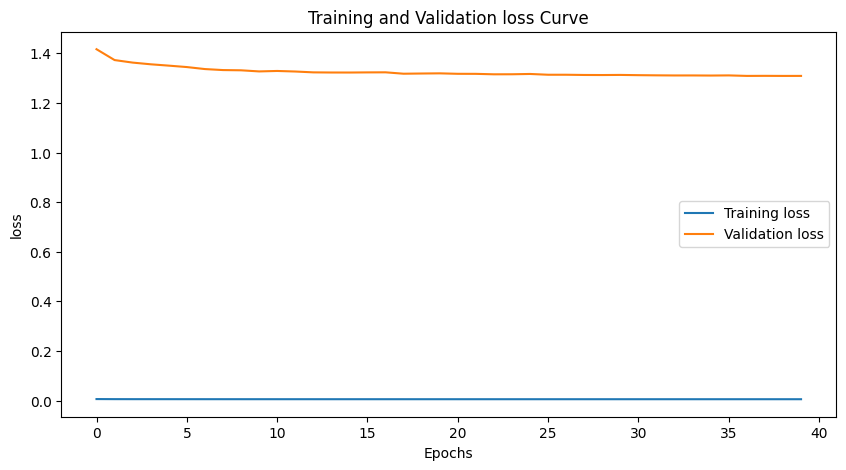

In [154]:
plot(train_loss, val_loss, "loss")

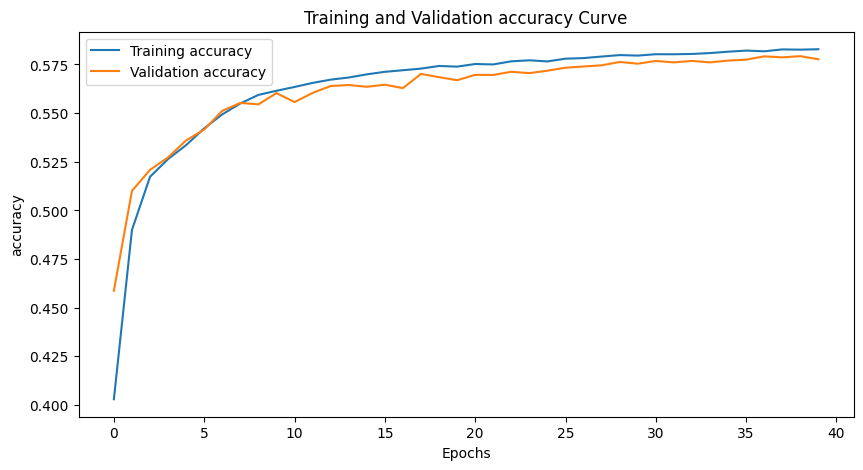

In [159]:
plot(train_acc, val_acc, "accuracy")

### Target_10

In [132]:
train_loss, train_acc, val_loss, val_acc = train(model, optimizer_gru, criterion_gru, 40, train_dataloader, val_dataloader, 
                                                 bagging_mode=False, validation_mode=True, NAL_loss=False, debug_mode=False)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40
***********************************************
Training loss: 4.4714368605054915
Training accuracy: 0.4138321578502655
-----------------------------------------------
Validation loss: 1.382843595378253
Validation accuracy: 0.512117326259613

Epoch 2/40
***********************************************
Training loss: 4.206779581494629
Training accuracy: 0.5304237008094788
-----------------------------------------------
Validation loss: 1.3659382730114216
Validation accuracy: 0.5258290767669678

Epoch 3/40
***********************************************
Training loss: 4.170418089721352
Training accuracy: 0.5433694124221802
-----------------------------------------------
Validation loss: 1.3567183321836043
Validation accuracy: 0.5377072691917419

Epoch 4/40
***********************************************
Training loss: 4.140300423838198
Training accuracy: 0.5527895092964172
-----------------------------------------------
Validation loss: 1.352288426185141
Validation accuracy: 0.

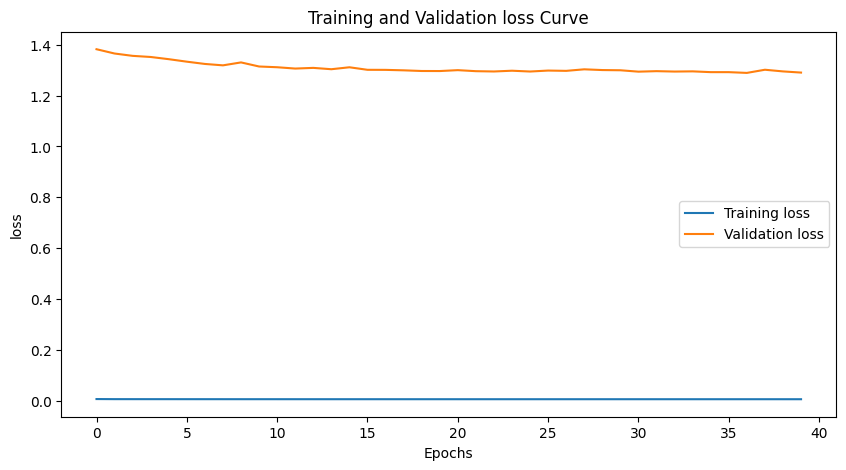

In [137]:
plot(train_loss, val_loss, "loss")

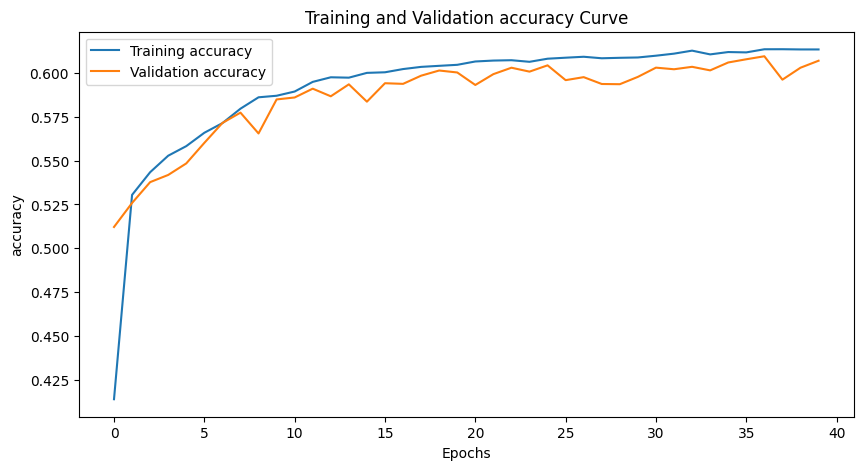

In [145]:
plot(train_acc, val_acc, "accuracy")